In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('/content/sample_data/transplantes.csv', sep = ';')
df = pd.DataFrame(data)
#df = df.set_index('Orgao')
df.head()

df['Num_tot'] = df[['Num_LE','Num_Transpl']].sum(axis=1)
for i in range(1, len(df)):
    
    if df.loc[i, 'Orgao'] == df.loc[i-1, 'Orgao']:
        df.loc[i, 'Num_Entr'] = df.loc[i, 'Num_LE'] - (df.loc[i-1, 'Num_LE'] - df.loc[i, 'Num_Transpl'])
    
    else:
        df.loc[i, 'Num_Entr'] = 0

df2 = df.set_index(['Orgao'])
df0 = df[df['Num_Entr'] > 0]
df2['Tr_avg'] = df.groupby("Orgao")["Num_Transpl"].mean()#.round(0) # Numero transplantes médio anual
df2['En_avg'] = df0.groupby('Orgao')['Num_Entr'].mean()#.round(0) # para calcular esta media tiramos o primeiro valor da Num_Entr (=0)
df2['Tot_avg'] = df.groupby('Orgao')['Num_tot'].mean()#.round(0) # Numero médio doentes no sistema
df2['avg_LE'] = df.groupby('Orgao')['Num_LE'].mean()#.round(0) # Numero médio de doentes em lista de espera

df2['week_En'] = df2['En_avg'] / 52
df2['week_Tr'] =df2['Tr_avg'] / 52
df2['Ro'] = df2['En_avg'] / df2['Tr_avg']


df3 = df2.round(3).reset_index()
df3.head(10)


,Orgao,ind,Periodo,Num_LE,Num_Transpl,Num_tot,Num_Entr,Tr_avg,En_avg,Tot_avg,avg_LE,week_En,week_Tr,Ro
0,coracao,1,2011,17,46,63,NaN,44.571,48.833,70.000,25.429,0.939,0.857,1.096
1,coracao,2,2012,42,30,72,55.0,44.571,48.833,70.000,25.429,0.939,0.857,1.096
2,coracao,3,2013,20,55,75,33.0,44.571,48.833,70.000,25.429,0.939,0.857,1.096
3,coracao,4,2014,19,43,62,42.0,44.571,48.833,70.000,25.429,0.939,0.857,1.096
4,coracao,5,2015,19,50,69,50.0,44.571,48.833,70.000,25.429,0.939,0.857,1.096
5,coracao,6,2016,17,42,59,40.0,44.571,48.833,70.000,25.429,0.939,0.857,1.096
6,coracao,7,2017,44,46,90,73.0,44.571,48.833,70.000,25.429,0.939,0.857,1.096
7,figado,8,2011,169,219,388,0.0,234.143,222.667,370.714,136.571,4.282,4.503,0.951
8,figado,9,2012,130,188,318,149.0,234.143,222.667,370.714,136.571,4.282,4.503,0.951
9,figado,10,2013,166,243,409,279.0,234.143,222.667,370.714,136.571,4.282,4.503,0.951


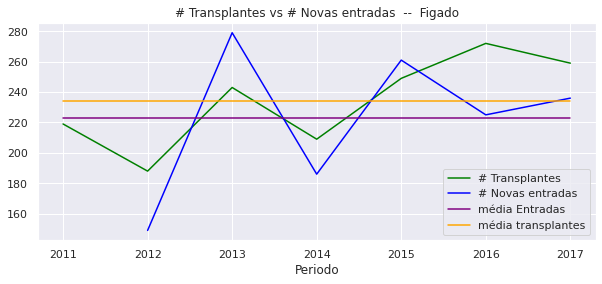

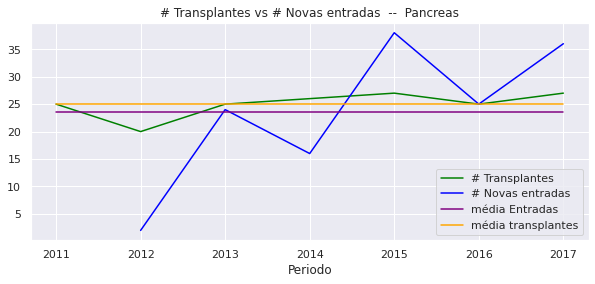

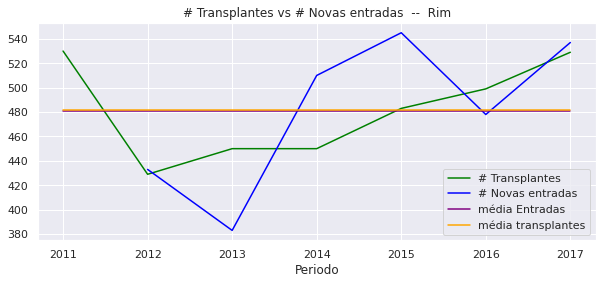

In [ ]:
fig = df3[df3['Orgao'] == 'figado'].set_index('Periodo')
pan = df3[df3['Orgao'] == 'pancreas'].set_index('Periodo')
rim = df3[df3['Orgao'] == 'Rim'].set_index('Periodo')

figure = plt.figure(figsize=(10, 4))
ax = figure.add_subplot(111)

fig.Num_Transpl.plot(kind = 'line', color = 'green', ax=ax, label = '# Transplantes')
fig.Num_Entr[1:].plot(kind = 'line', color = 'blue', ax=ax, label  = '# Novas entradas')
fig.En_avg.plot(kind = 'line', color = 'purple', ax=ax, label  = 'média Entradas')
fig.Tr_avg.plot(kind = 'line', color = 'orange', ax=ax, label  = 'média transplantes')
plt.title('# Transplantes vs # Novas entradas  --  Figado')
ax.legend(loc=4)
plt.show()

figure = plt.figure(figsize=(10, 4))
ax = figure.add_subplot(111)
pan.Num_Transpl.plot(kind = 'line', color = 'green', ax=ax, label = '# Transplantes')
pan.Num_Entr[1:].plot(kind = 'line', color = 'blue', ax=ax, label  = '# Novas entradas')
pan.En_avg.plot(kind = 'line', color = 'purple', ax=ax, label  = 'média Entradas')
pan.Tr_avg.plot(kind = 'line', color = 'orange', ax=ax, label  = 'média transplantes')
plt.title('# Transplantes vs # Novas entradas  --  Pancreas')
ax.legend(loc=4)
plt.show()

figure = plt.figure(figsize=(10, 4))
ax = figure.add_subplot(111)
rim.Num_Transpl.plot(kind = 'line', color = 'green', ax=ax, label = '# Transplantes')
rim.Num_Entr[1:].plot(kind = 'line', color = 'blue', ax=ax, label  = '# Novas entradas')
rim.En_avg.plot(kind = 'line', color = 'purple', ax=ax, label  = 'média Entradas')
rim.Tr_avg.plot(kind = 'line', color = 'orange', ax=ax, label  = 'média transplantes')
plt.title('# Transplantes vs # Novas entradas  --  Rim')
ax.legend(loc=4)
plt.show()

In [ ]:
# crear output diferente para cada sistema
# crear sistema idoneo, com o numero minimo de transplantes necessários para nao saturaçao. calcular os novos tempos de espera
print("L = número esperado de doentes no sistema\nLq = número esperado de doentes na fila")
print("W = tempo esperado dentro do sistema (Anos)\nWq = tempo esperado na fila (Anos)\n")
def prob_n (n, orgao):
    #base['Pn'] = base.pow(n,axis = 1) * (1 - base['Ro'])* (1 - base['Ro'])
    base = df3[df3['Orgao'] == orgao]
    base['P0'] = 1 - base['Ro'] # Probabilidade de encontrar o sistema vazio
    base['Ron'] = base['Ro'] ** n
    base['Pn'] = base['Ron'] * (1 - base['Ro']) # Probabilidade de encontrar N pessoas no sistema
    
    base['NO_Tr'] = base['avg_LE'] - (base['Tr_avg'] - base['En_avg']) # pacientes no sistema nao operados (a sumar nos pacientes totais)

    base['Lq'] =  (base['En_avg'] ** 2 / (base['Tr_avg'] * (base['Tr_avg'] - base['En_avg'])) + base['avg_LE']).round(0)#N. médio pessoas fila
    base['L'] = (base['En_avg'] / (base['Tr_avg'] - base['En_avg']) + base['avg_LE']).round(0) # numero médio pessoas em sistema 
    base['Wq'] =  base['Lq'] / base['En_avg'] # Tempo médio espera em fila
    base['W'] =  base['Wq'] + 1 / base['Tr_avg'] # Tempo médio espera no sistema
    
    # Quantos transplantes se devem fazer anualmente para ter uma saturaçao do 90%
    # Deste modo aumenta o numero de transplantes, a velocidade do sistema, mas o número total de doentes mantem-se
    base['Tr_min'] = (base['En_avg'] / 0.9).round(0)
    base['novos_Tr'] = (base['Tr_min'] - base['Tr_avg']).round(0)
    base['dif_rel'] = 100 * (base['Tr_min'] / base['Tr_avg']- 1).round(2)
    base['dif_Tr'] = (base['Tr_min'] - base['En_avg']).round(0)
    base['avg_LE2'] = (base['avg_LE'] - base['dif_Tr'] * 4).round(0)
    
    # Quais seriam os novos parametros de espera? Mesmas formulas mas com o numero minimo de transplantes anuais necessários
    base['Lq2'] = (base['En_avg'] ** 2 / abs(base['Tr_min'] * (base['Tr_min'] - base['En_avg'])) + base['avg_LE2']).round(0)
    base['L2'] = (base['En_avg'] / abs(base['Tr_min'] - base['En_avg']) + base['avg_LE2']).round(0)
    base['Wq2'] =  base['Lq2'] / base['En_avg']
    base['W2'] =  base['Wq2'] + 1 / base['Tr_min']
    
    base['Ro2'] = base['En_avg'] / base['Tr_min']
    
    
    
    output = base[['Orgao','Tr_avg','En_avg','Tot_avg','avg_LE','Ro','L','Lq','W','Wq']].round(3).drop_duplicates('Orgao')
    output['Tr_avg'] = output['Tr_avg'].round(0)
    output['En_avg'] = output['En_avg'].round(0)
    output['Tot_avg'] = output['Tot_avg'].round(0)
    output['avg_LE'] = output['avg_LE'].round(0)

    output = output.rename(columns = {'Tr_avg':'Transplantes_anual_avg','En_avg':'Entradas_anual_avg','Tot_avg':'Total_anual_avg','avg_LE':'Lista_espera_avg',
                                      'L':'pacientes_sistema','Lq':'pacientes_fila',
                                      'W':'Tempo_esperado_sistema(Anos)','Wq':'Tempo_esperado_fila(Anos)'})
    
    output2 = base[['Orgao','Tr_min','novos_Tr','dif_rel', 'L2','Lq2','W2','Wq2', 'avg_LE2']].round(3).drop_duplicates('Orgao')
    output2 = output2.rename(columns = {'Tr_min':'Total_necessarios','novos_Tr':'Novos_Transplantes_necessarios','dif_rel':'%_aumento',
                                        'L2':'pacientes_sistema','Lq2':'pacientes_fila',
                                        'W2':'Tempo_esperado_sistema(Anos)','Wq2':'Tempo_esperado_fila(Anos)', 'avg_LE2':'Lista_espera_avg'})
    output = output.set_index('Orgao')
    output2 = output2.set_index('Orgao')

    if orgao not in (['Pulmao','coracao']):
    #print(output)
        print("Situação atual do sistema {0}:".format(orgao))
        print(tabulate(output[['Transplantes_anual_avg','Entradas_anual_avg','Ro','Lista_espera_avg']], headers = 'keys', tablefmt = 'fancy_grid'),"\n")
        print("Pacientes e tempo esperado no sistema {0}:".format(orgao))
        print(tabulate(output[['pacientes_sistema','pacientes_fila','Tempo_esperado_sistema(Anos)','Tempo_esperado_fila(Anos)']], headers = 'keys', tablefmt = 'fancy_grid'),"\n")
    else:
        print("Situação atual do sistema {0}, Saturado:".format(orgao))
        print(tabulate(output[['Transplantes_anual_avg','Entradas_anual_avg','Ro','Lista_espera_avg']], headers = 'keys', tablefmt = 'fancy_grid'),"\n")
        #print("sistema {0} saturado, sao precisos {1} transplantes anuais para uma saturação do 90%". format(orgao, output['Tr_min']))
    print("Situação do sistema {0} com uma saturação máxima de 90%, 4 anos mais tarde ".format(orgao))
    print(tabulate(output2[['Total_necessarios','Novos_Transplantes_necessarios','%_aumento','Lista_espera_avg']], headers = 'keys', tablefmt = 'fancy_grid'),"\n")
    print(tabulate(output2[['pacientes_sistema','pacientes_fila','Tempo_esperado_sistema(Anos)','Tempo_esperado_fila(Anos)']], headers = 'keys', tablefmt = 'fancy_grid'),"\n")
    print("***************************************************\n")
    return base
prob_n(2,'figado')
prob_n(2,'pancreas')
prob_n(2,'Rim')
prob_n(2,'Pulmao')
prob_n(2,'coracao')


L = número esperado de doentes no sistema
Lq = número esperado de doentes na fila
W = tempo esperado dentro do sistema (Anos)
Wq = tempo esperado na fila (Anos)

Situação atual do sistema figado:
╒═════════╤══════════════════════════╤══════════════════════╤═══════╤════════════════════╕
│ Orgao   │   Transplantes_anual_avg │   Entradas_anual_avg │    Ro │   Lista_espera_avg │
╞═════════╪══════════════════════════╪══════════════════════╪═══════╪════════════════════╡
│ figado  │                      234 │                  223 │ 0.951 │                137 │
╘═════════╧══════════════════════════╧══════════════════════╧═══════╧════════════════════╛ 

Pacientes e tempo esperado no sistema figado:
╒═════════╤═════════════════════╤══════════════════╤════════════════════════════════╤═════════════════════════════╕
│ Orgao   │   pacientes_sistema │   pacientes_fila │   Tempo_esperado_sistema(Anos) │   Tempo_esperado_fila(Anos) │
╞═════════╪═════════════════════╪══════════════════╪═════════════════

,Orgao,ind,Periodo,Num_LE,Num_Transpl,Num_tot,Num_Entr,Tr_avg,En_avg,Tot_avg,avg_LE,week_En,week_Tr,Ro,P0,Ron,Pn,NO_Tr,Lq,L,Wq,W,Tr_min,novos_Tr,dif_rel,dif_Tr,avg_LE2,Lq2,L2,Wq2,W2,Ro2
0,coracao,1,2011,17,46,63,NaN,44.571,48.833,70.0,25.429,0.939,0.857,1.096,-0.096,1.201216,-0.115317,29.691,13.0,14.0,0.266213,0.28865,54.0,9.0,21.0,5.0,5.0,14.0,14.0,0.286691,0.30521,0.904315
1,coracao,2,2012,42,30,72,55.0,44.571,48.833,70.0,25.429,0.939,0.857,1.096,-0.096,1.201216,-0.115317,29.691,13.0,14.0,0.266213,0.28865,54.0,9.0,21.0,5.0,5.0,14.0,14.0,0.286691,0.30521,0.904315
2,coracao,3,2013,20,55,75,33.0,44.571,48.833,70.0,25.429,0.939,0.857,1.096,-0.096,1.201216,-0.115317,29.691,13.0,14.0,0.266213,0.28865,54.0,9.0,21.0,5.0,5.0,14.0,14.0,0.286691,0.30521,0.904315
3,coracao,4,2014,19,43,62,42.0,44.571,48.833,70.0,25.429,0.939,0.857,1.096,-0.096,1.201216,-0.115317,29.691,13.0,14.0,0.266213,0.28865,54.0,9.0,21.0,5.0,5.0,14.0,14.0,0.286691,0.30521,0.904315
4,coracao,5,2015,19,50,69,50.0,44.571,48.833,70.0,25.429,0.939,0.857,1.096,-0.096,1.201216,-0.115317,29.691,13.0,14.0,0.266213,0.28865,54.0,9.0,21.0,5.0,5.0,14.0,14.0,0.286691,0.30521,0.904315
5,coracao,6,2016,17,42,59,40.0,44.571,48.833,70.0,25.429,0.939,0.857,1.096,-0.096,1.201216,-0.115317,29.691,13.0,14.0,0.266213,0.28865,54.0,9.0,21.0,5.0,5.0,14.0,14.0,0.286691,0.30521,0.904315
6,coracao,7,2017,44,46,90,73.0,44.571,48.833,70.0,25.429,0.939,0.857,1.096,-0.096,1.201216,-0.115317,29.691,13.0,14.0,0.266213,0.28865,54.0,9.0,21.0,5.0,5.0,14.0,14.0,0.286691,0.30521,0.904315


In [ ]:
df_graf = df3[df3['Orgao'] == 'Rim'].copy()
lista = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.98,0.99]
data_graf = pd.DataFrame([])

def retain_LE(df,var_in,var_out):
    var_out = var_in.shift()
    return df

for i in lista:
  df_graf['Tr_min'] = (df_graf['En_avg'] / i).round(0)

  df_graf['LE'] = df_graf['avg_LE'] - (df_graf['Tr_min'] - df_graf['En_avg'])
  df_graf['LE'] = df_graf.loc[df_graf['LE'] <= 0, df_graf['LE']] = 0


  df_graf['L'] = (df_graf['En_avg'] / abs(df_graf['Tr_min'] - df_graf['En_avg']) + df_graf['avg_LE']).round(0)
  df_graf['Lq'] =  (df_graf['En_avg'] ** 2 / (df_graf['Tr_min'] * (df_graf['Tr_min'] - df_graf['En_avg'])) + df_graf['avg_LE']).round(0)
  df_graf['Wq'] =  df_graf['Lq'] / df_graf['En_avg']
  df_graf['W'] =  df_graf['Wq'] + 1 / df_graf['Tr_min']

  dic = {'Ro' : i,'Periodo': df_graf['Periodo'], 'Mu' : df_graf['Tr_min'],'Lambda' : df_graf['En_avg'], 'LE' : df_graf['LE'], 
         'L' : df_graf['L'], 'W' : df_graf['W'], 'avg_LE': df_graf['avg_LE']}
  data_graf_aux = pd.DataFrame(dic)
  #data_graf_aux = data_graf_aux.drop_duplicates()
  data_graf = pd.concat([data_graf,data_graf_aux], axis = 0)

data_graf[data_graf['Ro'] <= 0.5]


